In [1]:
%%capture capt
!pip install scikit-learn-extra
!pip install jellyfish
!pip install kneed[plot]

In [2]:
%%capture capt
import numpy as np
from sklearn_extra.cluster import KMedoids
from jellyfish import jaro_winkler_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from matplotlib.ticker import PercentFormatter
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Importation data

In [3]:
base_patient = pd.read_csv("../data/profil_patient.csv")

In [4]:
%%capture capt
p_soins = pd.read_csv("../data/parcours_soins.csv")

In [5]:
p_soins.head(3)

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
base_patient.head(3)

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,False,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,False,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,True,43,0,1,1,2


# Data Pre-processing

In [7]:
base_patient.Mort = base_patient.Mort.astype(int)
base_patient.CHOC = base_patient.CHOC.astype(int)
base_patient.BEN_SEX_COD = base_patient.BEN_SEX_COD-1

In [8]:
# on ne conserve que l'annee de la premiere hospitalisation

base_patient.date_h0 = pd.to_datetime(base_patient.date_h0).apply(lambda date: int(date.year))

# Lister tous les GHM

In [9]:
all_ghm = set()
for i in range(len(p_soins)):
    ghm_row = set(p_soins.iloc[i].dropna().tolist()[1:])
    all_ghm = all_ghm.union(ghm_row)   

In [10]:
nb_ghm = len(all_ghm)
print(nb_ghm)

2346


# Vecteur des parcours de GHM

In [11]:
X_patient = []
for i in range(len(base_patient)):
    ghm_row = p_soins.iloc[i].dropna().tolist()[1:]
    X_patient.append(ghm_row)

# Formules de distance entre string

In [12]:
def string_distance(s1, s2):
    # Compute distance between strings using the jaro winkler similarity formula
    return 1 - jaro_winkler_similarity(s1, s2)

def convert_to_sentence(arr):
    sentence = ''
    for x in arr:
        sentence += x + ","
    return sentence[:-1]

def jaro_winkler_distance(arr1, arr2):
    s1 = convert_to_sentence(arr1)
    s2 = convert_to_sentence(arr2)
    return abs(string_distance(s1, s2))

In [13]:
def custom_pairwise_distances_i_triangle(data, distance_function, i):
    distance_i = []
    for j in range(i):
        distance_i_j = distance_function(data[i], data[j])
        distance_i.append(distance_i_j)
    distance_i.append(0)
    return distance_i
    
def custom_pairwise_distances_triangle(data, distance_function):
    distances = []   
    for i in tqdm(range(len(data))):
        distance_i = custom_pairwise_distances_i_triangle(data, distance_function, i)
        distances.append(distance_i)
            
    return distances

def custom_pairwise_distances(data, distance_function):
    distances_triangle = custom_pairwise_distances_triangle(data, distance_function)
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            distances_triangle[i].append(distances_triangle[j][i])
    return distances_triangle

# K-Medoids sur les parcours de soins

### Calculate the custom pairwise distances

In [14]:
distances = custom_pairwise_distances(X_patient, jaro_winkler_distance)

100%|██████████| 10051/10051 [08:36<00:00, 19.46it/s]


## Determiner le nombre de clusters

#### Regle du coude pour déterminer le nombre optimal de clusters

In [15]:
inertia=[]
nb_clusters_max = int(np.sqrt(len(base_patient)))

for n_clusters in tqdm(range(2, nb_clusters_max)):
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
    kmedoids.fit(distances)
    
    inertia.append(kmedoids.inertia_)

100%|██████████| 98/98 [29:36<00:00, 18.13s/it]


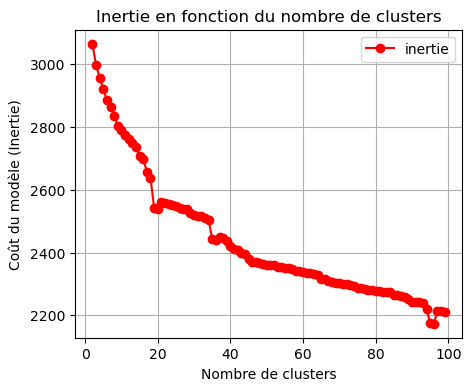

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(range(2, len(inertia)+2), inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()

In [17]:
k_elbow = KneeLocator(
  x=range(2, nb_clusters_max), 
  y=inertia, 
  curve="convex", 
  direction="decreasing").elbow

In [18]:
print(f"La méthode du coude nous indique que le nombre de clusters a faire = {k_elbow}")

La méthode du coude nous indique que le nombre de clusters a faire = 19


### BIC et Silhouette Scores

D'après ce papier: https://arxiv.org/abs/2212.12189 </br>
et ce code (https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb) qui compare plusieurs méthodes (Coude, Silhouette, Davies-Bouldin, Calinski-Harabasz, BIC), </br>
utiliser la méthode du coude n'est pas la meilleure option; il faut plutôt chercher à maximiser le score BIC, ou maximiser la silhouette (BIC donne des résultats très légèrement meilleurs). 

Tout est résumé ici: https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd

In [19]:
import warnings
warnings.simplefilter("ignore")

In [20]:
def bic_score(X, labels):

    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = np.shape(X)[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * np.pi * variance) \
          - (n_points_cluster - 1) / 2

        bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic

In [21]:
bic_scores = []
silhouette_scores = []
nb_clusters_max = int(np.sqrt(len(base_patient)))

for n_clusters in tqdm(range(2, nb_clusters_max)):
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
    kmedoids.fit(distances)
    
    try:
        bic = bic_score(distances, kmedoids.labels_)
        bic_scores.append(bic)
    except:
        bic_scores.append(-float('inf'))
        
    silhouette = silhouette_score(distances, kmedoids.labels_)
    silhouette_scores.append(silhouette)

100%|██████████| 98/98 [1:37:51<00:00, 59.91s/it]


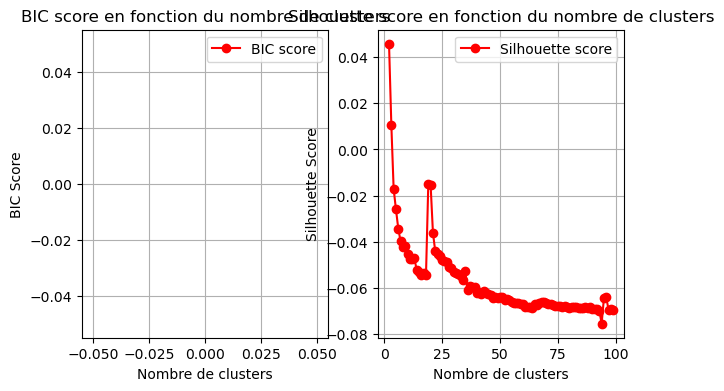

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))

#plot bic score
ax[0].plot(range(2, len(bic_scores)+2), bic_scores, c = 'r', label = 'BIC score', marker='o')
ax[0].legend(loc='best')
ax[0].grid('on')
ax[0].set_xlabel('Nombre de clusters')
ax[0].set_ylabel('BIC Score')
ax[0].set_title('BIC score en fonction du nombre de clusters')

#plot silhouette scores
ax[1].plot(range(2, len(silhouette_scores)+2), silhouette_scores, c = 'r', label = 'Silhouette score', marker='o')
ax[1].legend(loc='best')
ax[1].grid('on')
ax[1].set_xlabel('Nombre de clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette score en fonction du nombre de clusters')

plt.show()

In [23]:
k_elbow = KneeLocator(
  x=range(2, nb_clusters_max), 
  y=silhouette_scores, 
  curve="convex", 
  direction="decreasing").elbow

In [37]:
k_elbow

8

# Implement K-Medoids

In [39]:
n_clusters = 20

In [40]:
kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
kmedoids.fit(distances)

KMedoids(metric='precomputed', n_clusters=20)

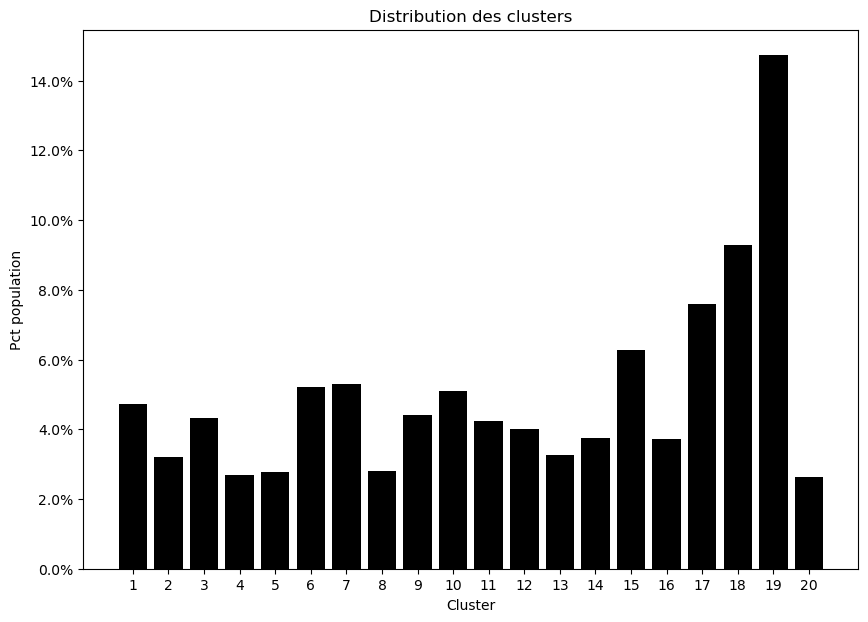

In [41]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(kmedoids.labels_, return_counts=True)
counts = counts / len(kmedoids.labels_)
plt.bar(labels+1, counts, align='center', color = 'black')
plt.gca().set_xticks(labels+1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution des clusters')
plt.xlabel("Cluster")
plt.ylabel('Pct population')
plt.show()

##### Ajout des clusters dans la base

In [27]:
base_patient = base_patient.drop(columns=["cluster"])

In [28]:
for i in range(1, n_clusters+1):
    base_patient["cluster"+str(i)] = [0]*len(base_patient)

In [29]:
for i, label in enumerate(kmedoids.labels_):
    base_patient.loc[i, "cluster"+str(label+1)] = 1

##### Ajout d'une colonne contenant les parcours de soins

In [30]:
base_patient['p_soins'] = ['']*len(base_patient)

In [31]:
for i, patient in enumerate(X_patient):
    p_soin = convert_to_sentence(patient)
    base_patient.loc[i, 'p_soins'] = p_soin

In [32]:
base_patient.head(3)

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,p_soins
0,P0,2011,1949,11,0,NaN,0,2596,9,0,...,0,0,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2..."
1,P6,2013,1929,14,1,2015-03,1,456,8,0,...,0,0,0,0,0,1,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0..."
2,P8,2015,1967,54,1,2015-08,1,41,3,1,...,0,0,0,0,0,0,1,0,0,"11M041,06C194"


In [33]:
base_patient.to_csv("../data/profil_patient_cluster.csv", index=False)

# Visualisation des clusters

In [42]:
clusters = kmedoids.labels_

##### Moyenne age

In [43]:
avg_ynais_cluster = [0]*n_clusters
for i in range(1, n_clusters+1):
    base_patient_cluster_i = base_patient.loc[base_patient["cluster" + str(i)] == 1]
    avg_ynais_cluster[i-1] = base_patient_cluster_i.y_nais.mean()

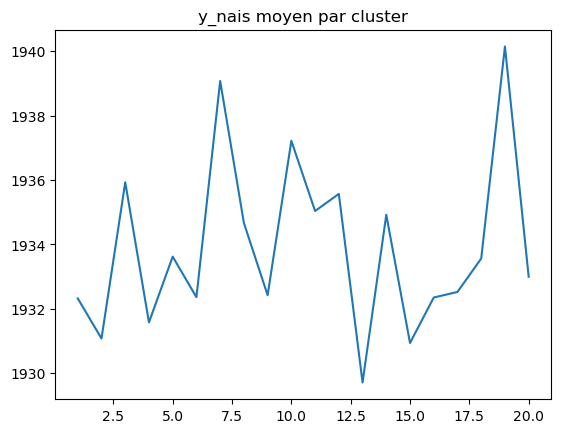

In [45]:
plt.plot(range(1, n_clusters+1), avg_ynais_cluster)
plt.title('y_nais moyen par cluster')
plt.show()